### Notebook to plot static stability characteristics (and CFADs) from BOWTIE sounding data.

James Ruppert  
jruppert@ou.edu  
8/19/24

### Main settings

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc, colors, ticker
import matplotlib.dates as mdates
from thermo_functions import *
import cmocean
import xarray as xr
import pandas as pd
import seaborn as sns
# import scipy.stats as stats
from time_series_diag import *
from bowtie_read_data import *

In [2]:
# Soundings
snd_asc, snd_files, times_asc = read_bowtie_soundings(search_string = 'ascen')
# soundings, snd_files, times_snd = read_bowtie_soundings(search_string = 'descen')
hght = snd_asc['hght']

### Compute diagnostics

In [3]:
# Vertical mass-weighted integral
#   inputs:
#       tmpk:   temperature [K]
#       mr:     water vapor mixing ratio [kg/kg]
#       p:      pressure [Pa]
#       hght:   height [m]
#   options:
#       minpres: set this to minimum pressure to integrate over [Pa]
def vert_integral(invar, tmpk, mr, p, hght, minpres=0):
    rho = density_moist(tmpk, mr, p) # kg/m3
    dz = hght[1]-hght[0] # m
    var_int = np.nansum(invar*rho, axis=1, where=(p > minpres))*dz
    var_int[ np.where(var_int == 0) ] = np.nan
    return var_int

# Vertical smoothing function
def vert_smooth(invar, nz_smooth=10):
    invar_pd = pd.DataFrame(invar)
    invar_pd = (invar_pd.transpose()).rolling(window=nz_smooth, center=True, closed='both', min_periods=3).mean()
    return np.squeeze(np.array(invar_pd).transpose())

In [4]:
# Constants
cp=1004.  # J/K/kg
cpl=4186. # J/k/kg
cpv=1885. # J/K/kg
lv0=2.5e6 # J/kg
g = 9.81 # m/s2
# Latent heat of vaporization
lv = lv0 - (cpl-cpv)*(snd_asc['tmpk']-273.15)

minpres=50e2 # Upper pressure bound for vertical integrals [Pa]

# MSE
dse = cp*snd_asc['tmpk'] + g*hght[np.newaxis,:]
lvq= lv*snd_asc['mr']
mse = dse + lvq

# Static stability
theta = theta_dry(snd_asc['tmpk'], snd_asc['p'])
# for ido in range(3):
theta = vert_smooth(theta, nz_smooth=10)
dthdz = np.gradient(theta, hght, axis=1) # K/m
dthdz = vert_smooth(dthdz, nz_smooth=10)

# tmpk_ddz = np.copy(snd_asc['tmpk'])
# for ido in range(3):
#     tmpk_ddz = smooth_theta(tmpk_ddz, nz_smooth=10)
# dtdz = np.gradient(tmpk_ddz, hght, axis=1) # K/m
# dtdz = smooth_theta(dtdz, nz_smooth=20)

# CWV/PW
# 1/g int(q)dp = s2/m * kg/m/s2 --> kg/m2 --> x1/rho_l --> 10^-3 kg/m2*m3/kg --> 10^-3m = mm
# int<q*rho>dz = kg/m3*m = kg/m2 = mm
cwv = vert_integral(snd_asc['mr'], snd_asc['tmpk'], snd_asc['mr'], snd_asc['p'],
                    hght, minpres=0) # mm or kg/m2

---
### Plotting routines

#### Plot functions

In [5]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 12}

rc('font', **font)

# sns.set_theme(style="darkgrid", rc={'xtick.bottom': True, 'ytick.left': True,})

##### Time-height series stuff

In [6]:
# def do_smooth(invar, nt_smooth=3, nz_smooth=10):
def do_smooth(invar, nt_smooth=8, nz_smooth=10):
    # Use Pandas to compute rolling average
    invar_pd = pd.DataFrame(invar)
    var_sm1 = invar_pd.rolling(window=nt_smooth, center=True, closed='both', min_periods=3).mean()
    # var_trns = var_sm1.transpose()
    # var_sm = var_trns.rolling(window=nz_smooth, center=True, closed='both', min_periods=3).mean()
    # var_sm = var_sm1.transpose()
    # return np.squeeze(np.array(var_sm.transpose()))
    return np.squeeze(np.array(var_sm1))

# def do_smooth(invar, nt_smooth=3, nz_smooth=10):
def do_smooth_2d(invar, nt_smooth=8):
    # Use Pandas to compute rolling average
    invar_pd = pd.DataFrame(invar)
    var_sm = invar_pd.rolling(window=nt_smooth, center=True, closed='both', min_periods=3).mean()
    return np.squeeze(np.array(var_sm))

In [7]:
def plot_time_height(figdata, smooth=False, top=18, do_log=False):

    fig_x = 9
    fig_y = 3.5
    fig, ax = plt.subplots(figsize=(fig_x,fig_y), layout="constrained",) # row, column

    ax.set_title(figdata['fig_title'])

    ax.set_ylabel('Height [km]')
    ax.set_ylim(0,top)
    # ax.set_xlim(figdata['xlim'])
    ax.set_xlabel('Date [UTC]')

    ax.grid(True, axis='x', color='0.55', linewidth=0.5, zorder=4)
    ax.grid(True, axis='y', color='0.55', linewidth=0.5, zorder=4)#, which='both')

    # Plot variable
    xdim=figdata['time']
    pltvar = figdata['pltvar']
    if smooth:
        pltvar = do_smooth(pltvar)

    # norm=colors.Normalize(np.min(figdata['clevels']), np.max(figdata['clevels']))
    # im = ax.pcolormesh(np.repeat(xdim[:,np.newaxis],len(hght),axis=1), np.repeat(hght[np.newaxis,:]*1e-3,len(xdim),axis=0), pltvar, cmap=figdata['cmap'], shading='gouraud', norm=norm)#figdata['norm'])
    im = ax.contourf(xdim, hght*1e-3, pltvar.transpose(), figdata['clevels'],
                    extend=figdata['extend'], cmap=figdata['cmap'], zorder=0)#, norm=norm)
    fig.colorbar(im, ax=ax, label=figdata['units'], ticks=ticker.AutoLocator())#, shrink=0.6)

    # Line contours
    im = ax.contour(xdim, hght*1e-3, pltvar.transpose(), figdata['clevels_line'],
                    colors=figdata['clevels_line_color'],linewidths=0.6, zorder=1)

    # 0ºC level
    hght0c = snd_asc['hght_0c']*1e-3
    if smooth:
        invar_pd = pd.DataFrame(hght0c)
        nt_smooth=3
        invar_sm = invar_pd.rolling(window=nt_smooth, center=True, closed='both', min_periods=3).mean()
        hght0c=np.squeeze(np.array(invar_sm))
    # ax.plot(figdata['time'], hght0c, color='#d62728', zorder=3, linewidth=2)

    # Time labels
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

    plt.show()
    plt.close()
    return

##### CFAD stuff

In [8]:
# def compute_cfad(invar, bins):
#     nz = invar.shape[1]
#     nbin = len(bins)
#     var_freq=np.zeros((nbin-1,nz))
#     for iz in range(nz):
#         count, placeholder = np.histogram(invar[:,iz], bins=bins)
#         # var_freq[:,iz] = 100 * count / np.sum(count)
#         var_freq[:,iz] = count
#     return var_freq
def compute_cfad(invar, bins):
    nz = invar.shape[1]
    nbin = len(bins)
    hist_density=np.zeros((nbin-1,nz))
    for iz in range(nz):
        count, bin_edges = np.histogram(invar[:,iz], bins=bins, density=True)
        hist_density[:,iz] = count
    return hist_density, bin_edges

In [9]:
def contour_cfad(fig, ax, cfad_var, x, y, meanvar=None, meanrh=None, zeroc=None, plot_legend=False, plot_cbar=False, ianom=False):
    if ianom:
        # norm=colors.Normalize(vmin=-5, vmax=5)
        norm=colors.Normalize(vmin=-.15, vmax=.15)
        cmap='RdBu_r'
    else:
        # norm=colors.Normalize(vmin=0, vmax=15)
        norm=colors.Normalize(vmin=0, vmax=0.25)
        cmap=cmocean.cm.rain
    ax.grid(True, axis='x', color='0.55', linewidth=0.5)
    ax.grid(True, axis='y', color='0.55', linewidth=0.5)#, which='both')
    im = ax.pcolormesh(x, y, cfad_var[:,:-1].transpose(), cmap=cmap, norm=norm)
    # fig.colorbar(im, ax=ax, label='Frequency [%]')#, shrink=0.6)
    if plot_cbar:
        fig.colorbar(im, ax=ax, label='Density', shrink=0.75)
    # Plot mean
    if meanvar is not None:
        ax.plot(meanvar, y, '-', color='#d62728', linewidth=1.9, label=r'Mean d$\theta$/dz')
    # Plot 0ºC
    if zeroc is not None:
        ax.axhline(y=zeroc*1e-3, color='black', linestyle='--', linewidth=1, label='0$^\circ$C')
    if meanrh is not None:
        # This is just to get it into the legend
        ax.axhline(y=zeroc*0, color='green', linewidth=2, label='Mean RH')
    if plot_legend:
        plt.legend(loc='upper left', prop={'size': 10})
    # Plot mean RH
    if meanrh is not None:
        twiny = ax.twiny()
        twiny.plot(meanrh, y, '-', color='green', linewidth=1.9)
        if ianom:
            twiny.set_xlim((-30,30))
        else:
            twiny.set_xlim((25,100))
    return None

In [10]:
def plot_mean_cfad(figdata, plot_legend=False, plot_cbar=False, ianom=False):

    fig_x = 5
    fig_y = 4.5
    fig, ax = plt.subplots(figsize=(fig_x,fig_y), layout="constrained",) # row, column

    ax.set_title(figdata['fig_title'])
    # fig.suptitle(figdata['fig_title'])

    ax.set_ylabel('Height [km]')
    ymax=16
    ax.set_xlim(figdata['bins'].min(),figdata['bins'].max())
    ax.set_ylim(0,ymax)
    ax.set_xlabel(figdata['xtitle'])

    # Plot CFAD
    contour_cfad(fig, ax, figdata['pltvar'], figdata['bins'], hght*1e-3,
                 meanvar=figdata['meanvar'], meanrh=figdata['mean_rh'], zeroc=figdata['zeroc'], plot_legend=plot_legend, plot_cbar=plot_cbar)

    plt.show()
    plt.close()
    return None

In [11]:
def plot_cfad_multi(figdata, fig, ax, plot_legend=False, plot_cbar=False, ianom=False):

    ax.set_title(figdata['fig_title'])

    ax.set_xlim(figdata['bins'].min(),figdata['bins'].max())
    ax.set_ylim(0,16)

    contour_cfad(fig, ax, figdata['pltvar'], figdata['bins'], hght*1e-3,
                 meanvar=figdata['meanvar'], meanrh=figdata['mean_rh'], zeroc=figdata['zeroc'], plot_legend=plot_legend, plot_cbar=plot_cbar, ianom=ianom)

    return None

#### Time-height series

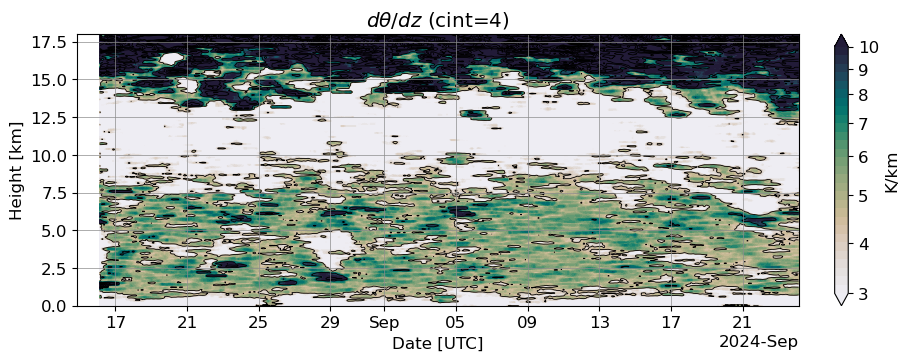

In [12]:
xlim=(times_asc[0],times_asc[-1])
# xlim=(times_asc[-48*2],times_asc[-1])
# xlim=[np.datetime64('2024-08-23T00:00'), np.datetime64('2024-08-27T00:00')]

# d(th)/dz

cint_lines = 4
contours = np.arange(cint_lines,cint_lines*10,cint_lines)

# dthdz_asc = np.copy(dthdz)
# dthdz_asc -= (np.nanmean(dthdz_asc, axis=0))[np.newaxis,:]

figdata = {
    'pltvar': dthdz*1e3,
    'time': times_asc,
    'fig_title': r'$d\theta/dz$ (cint='+str(cint_lines)+')',
    'units': 'K/km',
    'cmap': cmocean.cm.rain,
    'clevels': np.logspace(0.5,1.,num=30),
    'clevels_line': contours,
    'clevels_line_color': 'black',
    'extend': 'both',
    'xlim': xlim,
           }

plot_time_height(figdata, smooth=True, do_log=True)

#### CFADS

##### Mean CFAD

/Users/jamesruppert/mambaforge/envs/plotting/lib/python3.11/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/var/folders/9x/209ltwrn2b359nrrh4638hv40000gp/T/ipykernel_19727/4134268916.py:17: RuntimeWarning: Mean of empty slice
  var_mean = np.nanmean(cfad_invar, axis=0)
/var/folders/9x/209ltwrn2b359nrrh4638hv40000gp/T/ipykernel_19727/4134268916.py:20: RuntimeWarning: Mean of empty slice
  mean_rh = np.nanmean(rh_asc, axis=0)


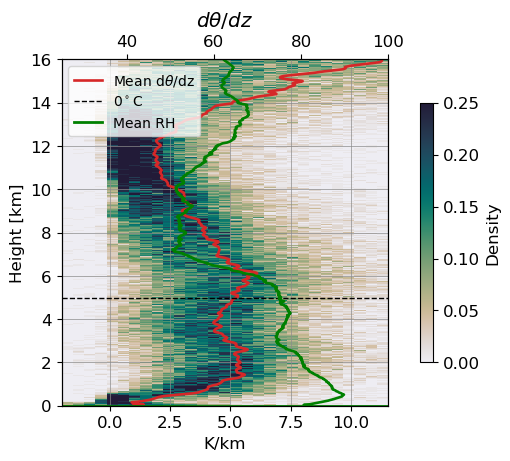

In [13]:
# Bin settings
# nbin=40
# fmin=-2
# fmax=10#15
# step=(fmax-fmin)/nbin
# bins=np.arange(fmin,fmax,step)+step
nbin=30
fmin=-2
fmax=12
step=(fmax-fmin)/nbin
bins=np.arange(fmin,fmax,step)

cfad_invar = dthdz*1e3 # K/km

# var_cfad = compute_cfad(cfad_invar, bins)
cfad_density, bin_edges = compute_cfad(cfad_invar, bins)
var_mean = np.nanmean(cfad_invar, axis=0)

rh_asc = calc_relh(snd_asc['mr'], snd_asc['p'], snd_asc['tmpk'], ice=True)
mean_rh = np.nanmean(rh_asc, axis=0)

figdata = {
    'pltvar': cfad_density,
    'meanvar': var_mean,
    'bins': bins,
    'zeroc': np.nanmean(snd_asc['hght_0c']),
    'mean_rh':  mean_rh,
    'fig_title': r'$d\theta/dz$',
    'xtitle': 'K/km',
    'extend': 'both',
           }

plot_mean_cfad(figdata, plot_cbar=True, plot_legend=True)

##### Binned by CWV

In [14]:
# # Apply STD thresholds to smoothed CWV to isolate dry/wet periods

# cwv_std = (cwv - np.nanmean(cwv)) / np.nanstd(cwv, axis=0)
# cwv_std = do_smooth_2d(cwv_std)
# std_thresh = .5
# it_dry = np.where(cwv_std < -1*std_thresh)[0]
# it_moist = np.where(cwv_std > std_thresh)[0]
# it_mid = np.where((cwv_std < std_thresh) & (cwv_std > -1*std_thresh))[0]
# print('Percent of full record:')
# print(it_dry.size/cwv.size*1e2)
# print(it_moist.size/cwv.size*1e2)
# print(it_mid.size/cwv.size*1e2)

In [15]:
# Percentile approach for partitioning data into dry/wet periods via CWV

percentiles = [33,66]

cwv_perc = np.nanpercentile(cwv, percentiles)

it_dry = np.where(cwv < cwv_perc[0])[0]
it_moist = np.where(cwv > cwv_perc[1])[0]
it_mid = np.where((cwv > cwv_perc[0]) & (cwv < cwv_perc[1]))[0]
print('Percent of full record:')
print(np.round(it_dry.size/cwv.size*1e2))
print(np.round(it_moist.size/cwv.size*1e2))
print(np.round(it_mid.size/cwv.size*1e2))

Percent of full record:
32.0
33.0
32.0


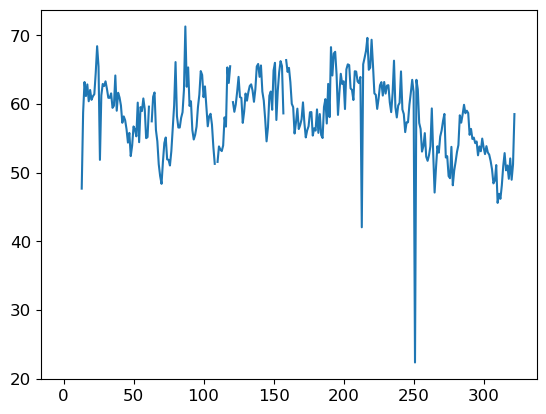

In [16]:
plt.plot(cwv)

/var/folders/9x/209ltwrn2b359nrrh4638hv40000gp/T/ipykernel_19727/596895884.py:12: RuntimeWarning: Mean of empty slice
  var_mean = np.nanmean(cfad_invar[it_dry], axis=0)
/var/folders/9x/209ltwrn2b359nrrh4638hv40000gp/T/ipykernel_19727/596895884.py:13: RuntimeWarning: Mean of empty slice
  mean_rh = np.nanmean(rh_asc[it_dry], axis=0)
/var/folders/9x/209ltwrn2b359nrrh4638hv40000gp/T/ipykernel_19727/596895884.py:38: RuntimeWarning: Mean of empty slice
  var_mean = np.nanmean(cfad_invar[it_mid], axis=0)
/var/folders/9x/209ltwrn2b359nrrh4638hv40000gp/T/ipykernel_19727/596895884.py:40: RuntimeWarning: Mean of empty slice
  mean_rh = np.nanmean(rh_asc[it_mid], axis=0)
/var/folders/9x/209ltwrn2b359nrrh4638hv40000gp/T/ipykernel_19727/596895884.py:58: RuntimeWarning: Mean of empty slice
  var_mean = np.nanmean(cfad_invar[it_moist], axis=0)
/var/folders/9x/209ltwrn2b359nrrh4638hv40000gp/T/ipykernel_19727/596895884.py:60: RuntimeWarning: Mean of empty slice
  mean_rh = np.nanmean(rh_asc[it_moist],

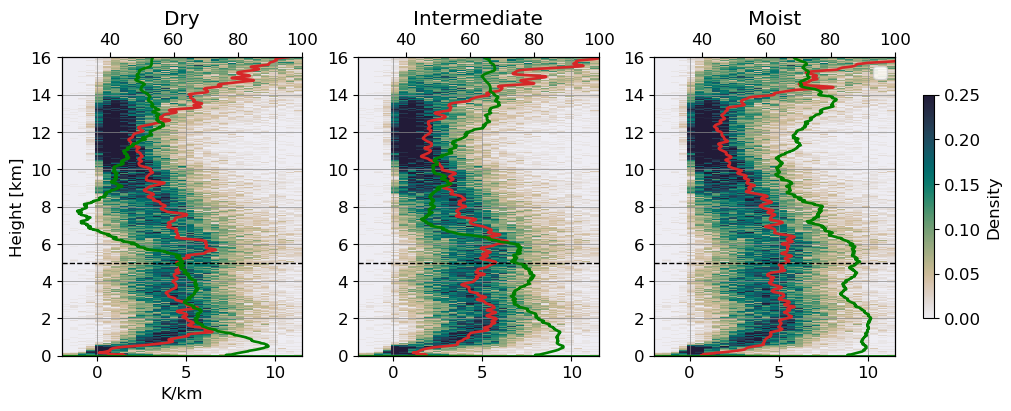

In [17]:
# Dependence on moisture

# Bin settings
nbin=30
fmin=-2
fmax=12
step=(fmax-fmin)/nbin
bins=np.arange(fmin,fmax,step)

# var_cfad = compute_cfad(cfad_invar[it_dry], bins)
cfad_density, bin_edges = compute_cfad(cfad_invar, bins)
var_mean = np.nanmean(cfad_invar[it_dry], axis=0)
mean_rh = np.nanmean(rh_asc[it_dry], axis=0)

fig_x = 10
fig_y = 4.
fig, axs = plt.subplots(1,3, figsize=(fig_x,fig_y), layout="constrained",) # row, column

figdata = {
    'pltvar': cfad_density,
    'meanvar': var_mean,
    'bins': bins,
    'zeroc': np.nanmean(snd_asc['hght_0c']),
    'mean_rh':  mean_rh,
    'fig_title': 'Dry',#r'$d\theta/dz$',
    'xtitle': 'K/km',
    'extend': 'both',
           }

plot_cfad_multi(figdata, fig, axs[0])

axs[0].set_ylabel('Height [km]')
axs[0].set_xlabel(figdata['xtitle'])

################################################

var_cfad = compute_cfad(cfad_invar[it_mid], bins)
var_mean = np.nanmean(cfad_invar[it_mid], axis=0)

mean_rh = np.nanmean(rh_asc[it_mid], axis=0)

figdata = {
    'pltvar': cfad_density,
    'meanvar': var_mean,
    'bins': bins,
    'zeroc': np.nanmean(snd_asc['hght_0c']),
    'mean_rh':  mean_rh,
    'fig_title': 'Intermediate',#r'$d\theta/dz$',
    'xtitle': 'K/km',
    'extend': 'both',
           }

plot_cfad_multi(figdata, fig, axs[1])

################################################

var_cfad = compute_cfad(cfad_invar[it_moist], bins)
var_mean = np.nanmean(cfad_invar[it_moist], axis=0)

mean_rh = np.nanmean(rh_asc[it_moist], axis=0)

figdata = {
    'pltvar': cfad_density,
    'meanvar': var_mean,
    'bins': bins,
    'zeroc': np.nanmean(snd_asc['hght_0c']),
    'mean_rh':  mean_rh,
    'fig_title': 'Moist',#r'$d\theta/dz$',
    'xtitle': 'K/km',
    'extend': 'both',
           }

plot_cfad_multi(figdata, fig, axs[2], plot_cbar=True)

plt.legend()

plt.show()
plt.close()

/var/folders/9x/209ltwrn2b359nrrh4638hv40000gp/T/ipykernel_19727/3789259137.py:28: RuntimeWarning: Mean of empty slice
  var_mean_int = np.nanmean(cfad_invar[it_mid], axis=0)
/var/folders/9x/209ltwrn2b359nrrh4638hv40000gp/T/ipykernel_19727/3789259137.py:29: RuntimeWarning: Mean of empty slice
  mean_rh_int = np.nanmean(rh_asc[it_mid], axis=0)
/var/folders/9x/209ltwrn2b359nrrh4638hv40000gp/T/ipykernel_19727/3789259137.py:34: RuntimeWarning: Mean of empty slice
  var_mean = np.nanmean(cfad_invar[it_dry], axis=0) - var_mean_int
/var/folders/9x/209ltwrn2b359nrrh4638hv40000gp/T/ipykernel_19727/3789259137.py:35: RuntimeWarning: Mean of empty slice
  mean_rh = np.nanmean(rh_asc[it_dry], axis=0) - mean_rh_int
/var/folders/9x/209ltwrn2b359nrrh4638hv40000gp/T/ipykernel_19727/3789259137.py:57: RuntimeWarning: Mean of empty slice
  mean_rh = np.nanmean(rh_asc[it_mid], axis=0)
/Users/jamesruppert/mambaforge/envs/plotting/lib/python3.11/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: inva

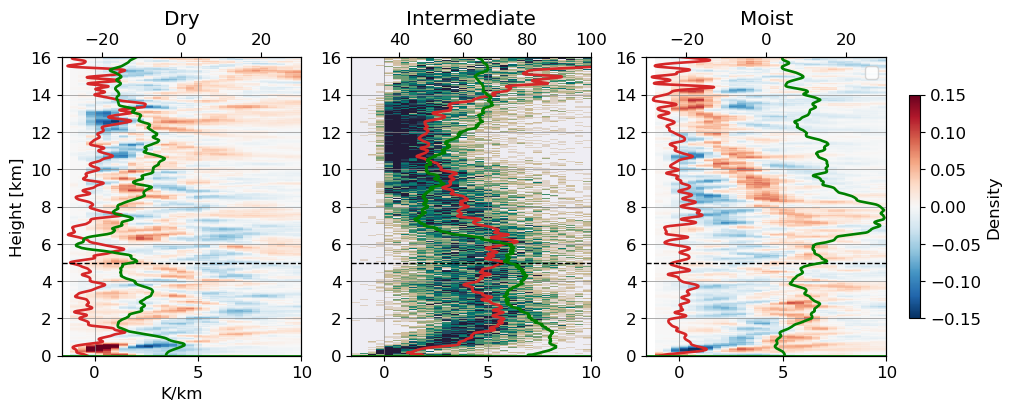

In [18]:
def cfad_smooth(invar, nx_smooth=3, nz_smooth=15):
    invar_pd = pd.DataFrame(invar)
    var_sm1 = invar_pd.rolling(window=nx_smooth, center=True, closed='both', min_periods=3).mean()
    var_trns = var_sm1.transpose()
    var_sm = var_trns.rolling(window=nz_smooth, center=True, closed='both', min_periods=3).mean()
    # var_sm = var_sm2.transpose()
    return np.squeeze(np.array(var_sm.transpose()))
def prof_smooth(invar, nx_smooth=15):
    invar_pd = pd.DataFrame(invar)
    var_sm1 = invar_pd.rolling(window=nx_smooth, center=True, closed='both', min_periods=3).mean()
    return np.squeeze(np.array(var_sm1))

# Dependence on moisture

# Bin settings
nbin=30
fmin=-2
fmax=10#15
step=(fmax-fmin)/nbin
bins=np.arange(fmin,fmax,step)+step

fig_x = 10
fig_y = 4.
fig, axs = plt.subplots(1,3, figsize=(fig_x,fig_y), layout="constrained",) # row, column

# var_cfad_int = compute_cfad(cfad_invar[it_mid], bins)
cfad_density_int, bin_edges = compute_cfad(cfad_invar[it_mid], bins)
var_mean_int = np.nanmean(cfad_invar[it_mid], axis=0)
mean_rh_int = np.nanmean(rh_asc[it_mid], axis=0)

# var_cfad = compute_cfad(cfad_invar[it_dry], bins) - var_cfad_int
cfad_density, bin_edges = compute_cfad(cfad_invar[it_dry], bins)
cfad_density -= cfad_density_int
var_mean = np.nanmean(cfad_invar[it_dry], axis=0) - var_mean_int
mean_rh = np.nanmean(rh_asc[it_dry], axis=0) - mean_rh_int

figdata = {
    'pltvar': cfad_smooth(cfad_density),
    # 'meanvar': var_mean,
    'meanvar': prof_smooth(var_mean),
    'bins': bins,
    'zeroc': np.nanmean(snd_asc['hght_0c']),
    # 'mean_rh':  mean_rh,
    'mean_rh':  prof_smooth(mean_rh),
    'fig_title': 'Dry',#r'$d\theta/dz$',
    'xtitle': 'K/km',
    'extend': 'both',
           }

plot_cfad_multi(figdata, fig, axs[0], ianom=True)

axs[0].set_ylabel('Height [km]')
axs[0].set_xlabel(figdata['xtitle'])

################################################

mean_rh = np.nanmean(rh_asc[it_mid], axis=0)

figdata = {
    'pltvar': cfad_density_int,
    'meanvar': var_mean_int,
    'bins': bins,
    'zeroc': np.nanmean(snd_asc['hght_0c']),
    'mean_rh':  mean_rh,
    'fig_title': 'Intermediate',#r'$d\theta/dz$',
    'xtitle': 'K/km',
    'extend': 'both',
           }

plot_cfad_multi(figdata, fig, axs[1])

################################################

# var_cfad = compute_cfad(cfad_invar[it_moist], bins) - var_cfad_int
cfad_density, bin_edges = compute_cfad(cfad_invar[it_moist], bins)
cfad_density -= cfad_density_int
var_mean = np.nanmean(cfad_invar[it_moist], axis=0) - var_mean_int
mean_rh = np.nanmean(rh_asc[it_moist], axis=0) - mean_rh_int

figdata = {
    'pltvar': cfad_smooth(cfad_density),
    # 'meanvar': var_mean,
    'meanvar': prof_smooth(var_mean),
    'bins': bins,
    'zeroc': np.nanmean(snd_asc['hght_0c']),
    # 'mean_rh':  mean_rh,
    'mean_rh':  prof_smooth(mean_rh),
    'fig_title': 'Moist',#r'$d\theta/dz$',
    'xtitle': 'K/km',
    'extend': 'both',
           }

plot_cfad_multi(figdata, fig, axs[2], plot_cbar=True, ianom=True)

plt.legend()

plt.show()
plt.close()

##### Binned by Midlevel RH

In [19]:
# Percentile approach for partitioning data into dry/wet periods via CWV

hght0 = 4.5 # km
hght1 = 6.5 # km
rh_midlev = np.nanmean(rh_asc[:,np.where((hght*1e-3 > hght0) & (hght*1e-3 < hght1))[0]], axis=1)

percentiles = [33,66]

rh_perc = np.nanpercentile(rh_midlev, percentiles)

it_dry = np.where(rh_midlev < rh_perc[0])[0]
it_moist = np.where(rh_midlev > rh_perc[1])[0]
it_mid = np.where((rh_midlev > rh_perc[0]) & (rh_midlev < rh_perc[1]))[0]
print('Percent of full record:')
print(np.round(it_dry.size/rh_midlev.size*1e2))
print(np.round(it_moist.size/rh_midlev.size*1e2))
print(np.round(it_mid.size/rh_midlev.size*1e2))

Percent of full record:
31.0
33.0
31.0


/var/folders/9x/209ltwrn2b359nrrh4638hv40000gp/T/ipykernel_19727/3425794239.py:5: RuntimeWarning: Mean of empty slice
  rh_midlev = np.nanmean(rh_asc[:,np.where((hght*1e-3 > hght0) & (hght*1e-3 < hght1))[0]], axis=1)


/Users/jamesruppert/mambaforge/envs/plotting/lib/python3.11/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/var/folders/9x/209ltwrn2b359nrrh4638hv40000gp/T/ipykernel_19727/1217263937.py:16: RuntimeWarning: Mean of empty slice
  var_mean = np.nanmean(cfad_invar[it_dry], axis=0)
/var/folders/9x/209ltwrn2b359nrrh4638hv40000gp/T/ipykernel_19727/1217263937.py:18: RuntimeWarning: Mean of empty slice
  mean_rh = np.nanmean(rh_asc[it_dry], axis=0)
/var/folders/9x/209ltwrn2b359nrrh4638hv40000gp/T/ipykernel_19727/1217263937.py:40: RuntimeWarning: Mean of empty slice
  var_mean = np.nanmean(cfad_invar[it_mid], axis=0)
/var/folders/9x/209ltwrn2b359nrrh4638hv40000gp/T/ipykernel_19727/1217263937.py:42: RuntimeWarning: Mean of empty slice
  mean_rh = np.nanmean(rh_asc[it_mid], axis=0)
/var/folders/9x/209ltwrn2b359nrrh4638hv40000gp/T/ipykernel_19727/1217263937.py:61: RuntimeWarning: Mean of empty slice
  var_mean = np.nan

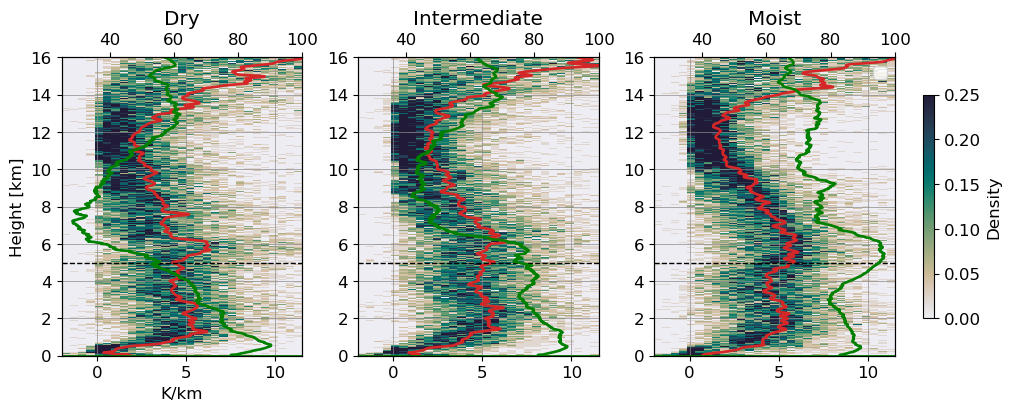

In [20]:
# Dependence on moisture

# Bin settings
nbin=30
fmin=-2
fmax=12
step=(fmax-fmin)/nbin
bins=np.arange(fmin,fmax,step)

fig_x = 10
fig_y = 4.
fig, axs = plt.subplots(1,3, figsize=(fig_x,fig_y), layout="constrained",) # row, column

# var_cfad = compute_cfad(cfad_invar[it_dry], bins)
cfad_density, bin_edges = compute_cfad(cfad_invar[it_dry], bins)
var_mean = np.nanmean(cfad_invar[it_dry], axis=0)

mean_rh = np.nanmean(rh_asc[it_dry], axis=0)

figdata = {
    'pltvar': cfad_density,
    'meanvar': var_mean,
    'bins': bins,
    'zeroc': np.nanmean(snd_asc['hght_0c']),
    'mean_rh':  mean_rh,
    'fig_title': 'Dry',#r'$d\theta/dz$',
    'xtitle': 'K/km',
    'extend': 'both',
           }

plot_cfad_multi(figdata, fig, axs[0])

axs[0].set_ylabel('Height [km]')
axs[0].set_xlabel(figdata['xtitle'])

################################################

# var_cfad = compute_cfad(cfad_invar[it_mid], bins)
cfad_density, bin_edges = compute_cfad(cfad_invar[it_mid], bins)
var_mean = np.nanmean(cfad_invar[it_mid], axis=0)

mean_rh = np.nanmean(rh_asc[it_mid], axis=0)

figdata = {
    'pltvar': cfad_density,
    'meanvar': var_mean,
    'bins': bins,
    'zeroc': np.nanmean(snd_asc['hght_0c']),
    'mean_rh':  mean_rh,
    'fig_title': 'Intermediate',#r'$d\theta/dz$',
    'xtitle': 'K/km',
    'extend': 'both',
           }

plot_cfad_multi(figdata, fig, axs[1])

################################################

# var_cfad = compute_cfad(cfad_invar[it_moist], bins)
cfad_density, bin_edges = compute_cfad(cfad_invar[it_moist], bins)
var_mean = np.nanmean(cfad_invar[it_moist], axis=0)

mean_rh = np.nanmean(rh_asc[it_moist], axis=0)

figdata = {
    'pltvar': cfad_density,
    'meanvar': var_mean,
    'bins': bins,
    'zeroc': np.nanmean(snd_asc['hght_0c']),
    'mean_rh':  mean_rh,
    'fig_title': 'Moist',#r'$d\theta/dz$',
    'xtitle': 'K/km',
    'extend': 'both',
           }

plot_cfad_multi(figdata, fig, axs[2], plot_cbar=True)

plt.legend()

plt.show()
plt.close()